### Single plot
demonstrating the evolution of recrystillization fraction over time for use in the read me.

In [4]:
from matplotlib import pyplot as plt
import pandas as pd
from matplotlib import rc
import pickle
rc('font',**{'family':'serif','serif':['Times New Roman'],'weight': 'bold'})
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
rc('text', usetex=True)
plt.rcParams['text.latex.preamble'] = "".join([r"\usepackage{newtxtext,newtxmath}",r"\boldmath"])

#path stuff
from pathlib import WindowsPath, PosixPath
import sys
PathPath = WindowsPath if 'win' in sys.platform.lower() else PosixPath
PARENT_DIR = PathPath('../')
DATA_DIR = PARENT_DIR.joinpath('rf_data')
MODEL_PATH = PARENT_DIR.joinpath('.model')
INFERENCE_PATH = PARENT_DIR.joinpath('.inference')  
GIT_IMAGE_PATH = PARENT_DIR.joinpath('.git_images')
GIT_TABLE_PATH = PARENT_DIR.joinpath('.git_tables')
sys.path.append(str(PARENT_DIR))
from common_util import setup_axis_default,get_data_label,gl_fit_model_setup,get_data_multiplier

import warnings
from jax import numpy as jnp
import numpy as np
from numpyro.distributions import Normal    
from jax import vmap
from jax import random
rng_key = random.PRNGKey(136)

from typing import Tuple,Callable
import numpyro

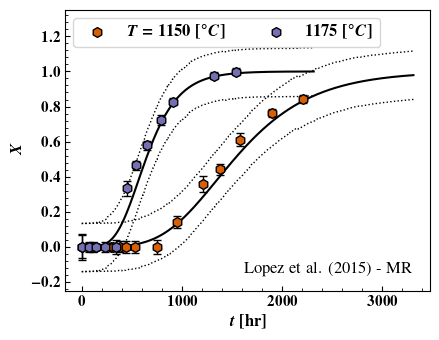

In [32]:

def ft_glm_model(t: float,
              T:float,
              a1: jnp.ndarray,
              B1: jnp.ndarray,
              a2: jnp.ndarray,
              B2: jnp.ndarray,
              nu: jnp.ndarray,
              sigma: jnp.ndarray = None) -> jnp.ndarray:
    
    error = 0.0 if sigma is None else Normal(0,sigma).rsample(random.PRNGKey(B1.astype(int)//10))

    B = jnp.exp(a1 + B1/T)
    M = jnp.exp(a2 + B2/T)
    return (1.+ jnp.exp(-B*(t - M)))**(-1./nu) + error

def glm_model(t: jnp.ndarray,
              T:float,
              a1: jnp.ndarray,
              B1: jnp.ndarray,
              a2: jnp.ndarray,
              B2: jnp.ndarray,
              nu: jnp.ndarray,
              sigma: jnp.ndarray = None) -> jnp.ndarray:
    
    def single_time(tt: float) -> float:
        return vmap(ft_glm_model,in_axes = (None,None,0,0,0,0,0,0))(tt,T,a1,B1,a2,B2,nu,sigma)
    
    return vmap(single_time,in_axes = (0))(t)

def plot_posterior_prediction(ax: plt.Axes,
                              posterior_samples: pd.DataFrame,
                              ml_est: np.ndarray,
                              temperature: float,
                              exp_data: pd.DataFrame,
                              style: str = '-',
                              pred_color: str = 'k') -> None:
    
    """
    helper function to plot posterior prediction summaries.
    """
    data = exp_data.loc[exp_data['temperature'] == temperature]
    t = np.linspace(data['time'].min()*0.5,data['time'].max()*1.5,1000)

    #sample from the posterior predictive
    predictions = glm_model(t,temperature + 273.15,
                            *(jnp.array(posterior_samples[a]) for a in ['a1','B1','a2','B2','nu','sigma'])).T

    #Estimate using ML parameters
    ml_pred = glm_model(t,(temperature + 273.15),
                         *(jnp.array([ml_est[a]]) for a in ['a1','B1','a2','B2','nu']))

    #Confidence Intervals using HPDI
    lower,upper = numpyro.diagnostics.hpdi(predictions,0.95)

    #Visualize the results using ML + HPDI
    ax.plot(t/3600,ml_pred,color = pred_color,lw = 1.5,ls = style)
    ax.plot(t/3600,lower,color = 'k',lw = 1.0,ls = ':')
    ax.plot(t/3600,upper,color = 'k',lw = 1.0,ls = ':')  
    

def plot_experimental_data(ax: plt.Axes,
                           exp_data: pd.DataFrame,
                           temperature: float,
                           color: str,
                           first_label = True,
                           make_label = True) -> None:
    
    """
    helper function to plot data.
    """

    label = r'\textbf{$T = ' + f'{temperature}$' + r' [$^\circ C $]}' if first_label else  r'\textbf{' rf'${temperature}$' + r' [$^\circ C $]}'
    data = exp_data.loc[exp_data['temperature'] == temperature]
    
    #plot the data and error bars
    ax.scatter(data['time']/3600,data['X'],facecolor = color,s = 50,
            edgecolor = 'k',zorder = 100,marker = 'h',
            label = label if make_label else None)
    ax.errorbar(data['time']/3600,data['X'],yerr = data['std'],color = 'k',
                fmt = 'none',capsize = 3,elinewidth = 1.0)
    

model_name = 'Generalized Logistic_{}'
file = DATA_DIR.joinpath('alfonso_data/moderate_roll.csv')

with open(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_samples.pkl'),'rb') as f:
    posterior_samples = pickle.load(f)

inf_summary = pd.read_csv(INFERENCE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_params.csv'),index_col = 0)['ml']

fig,ax = plt.subplots(figsize = (4.5,3.5))
setup_axis_default(ax)
t,T,X,df,bounds,p0 = gl_fit_model_setup(file, mult = get_data_multiplier(file))

for i,temp,color in zip(range(2),[1150,1175],plt.get_cmap('Dark2')([0.2,0.3])):
    plot_experimental_data(ax,df,temp,color,first_label = i == 0)
    plot_posterior_prediction(ax,posterior_samples,inf_summary,temp,df)


ax.set_xlabel(r'$t$ \textbf{[hr]}',fontsize = 12)
ax.set_ylabel(r'$X$',fontsize = 12)
ax.text(0.95, 0.05, get_data_label(file) , ha='right', va='bottom', transform=ax.transAxes, fontsize=12)
ax.legend(loc = 'upper left',fontsize = 12,ncols = 2)
fig.tight_layout()
ax.set_ylim(-0.25,1.35)
fig.savefig(GIT_IMAGE_PATH.joinpath(f'{model_name.format(get_data_label(file))}_data_example.svg'))
